In [1]:
import CMGDB

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import time
import math
import csv

## Scikit Learn GP

In [2]:
# Define a Gaussian process
def GP(X_train, Y_train):
    # fit Gaussian Process with dataset X_train, Y_train
    kernel = RBF(0.5, (0.01, 2)) + WhiteKernel()
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(X_train, Y_train)
    return gp

In [3]:
# Load data from file
data = np.loadtxt('PO_50.dat')
# data = np.loadtxt('PO_100.dat')

# Get X and Y vectors
X = data[:, [0,1]]
Y = data[:, [2,3]]

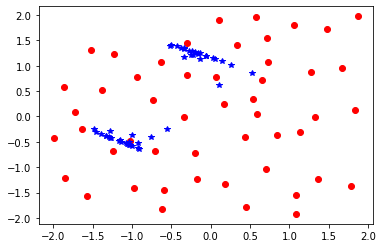

In [4]:
# Plot data
plt.plot(X[:,0], X[:,1], 'ro', Y[:,0], Y[:,1], 'b*');

In [5]:
# Train a GP with the data above
gp = GP(X, Y)

In [6]:
# Use the GP to define a map f
# Notice that the GP takes lists as
# input and output, so we need to
# add the [] below
def f(X):
    return gp.predict([X])[0]

# Define box map for f
def F(rect):
    return CMGDB.BoxMap(f, rect, padding=True)

Now we can use the map F above to compute the Morse graph

In [7]:
# Define the parameters for CMGDB
lower_bounds = [-2.0, -2.0]
upper_bounds = [2.0, 2.0]

subdiv_min = 15
subdiv_max = 20

morse_fname = 'morse_sets_Scikit.csv'

In [8]:
%%time
morse_graph = CMGDB.MorseGraphMap(subdiv_min, subdiv_max, lower_bounds,
                                  upper_bounds, morse_fname, F)

CPU times: user 2.62 s, sys: 21.9 ms, total: 2.64 s
Wall time: 2.72 s


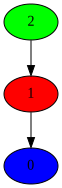

In [9]:
# Plot Morse graph
CMGDB.PlotMorseGraph(morse_graph)

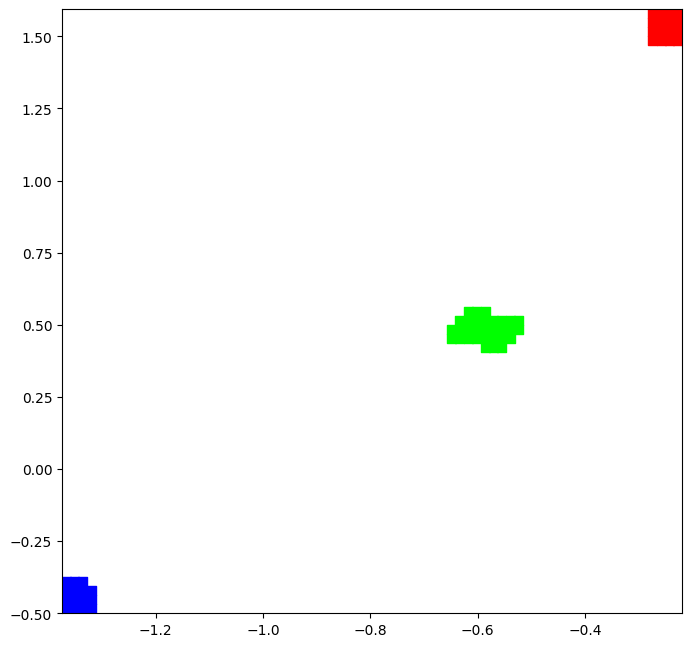

In [10]:
# Plot Morse sets
CMGDB.PlotMorseSets(morse_fname)

## GPflow GP

In [11]:
import gpflow

In [12]:
# Choose kernel
kernel = gpflow.kernels.Matern52()

# Define model
model = gpflow.models.GPR(data=(X, Y), kernel=kernel, mean_function=None)

# Choose optimizer
optimizer = gpflow.optimizers.Scipy()

In [13]:
# Run optimizer
optimizer_logs = optimizer.minimize(model.training_loss, model.trainable_variables,
                                    options=dict(maxiter=100))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [14]:
def f(X):
    Y, var = model.predict_f(np.array([X]))
    return np.array(Y)[0]
    # return np.array(model.predict_f(np.array([X]))[0])[0]

# Define box map for f
def F(rect):
    return CMGDB.BoxMap(f, rect, padding=True)

In [15]:
# Define the parameters for CMGDB
lower_bounds = [-2.0, -2.0]
upper_bounds = [2.0, 2.0]

subdiv_min = 15
subdiv_max = 20

morse_fname = 'morse_sets_GPflow.csv'

In [16]:
%%time
morse_graph = CMGDB.MorseGraphMap(subdiv_min, subdiv_max, lower_bounds,
                                  upper_bounds, morse_fname, F)

CPU times: user 2min 56s, sys: 1.13 s, total: 2min 57s
Wall time: 3min 52s


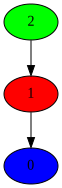

In [17]:
# Plot Morse graph
CMGDB.PlotMorseGraph(morse_graph)

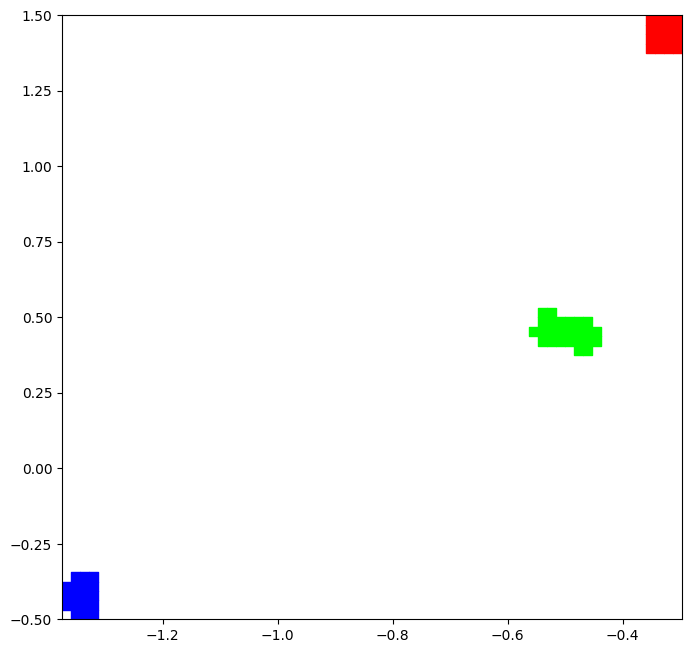

In [18]:
# Plot Morse sets
CMGDB.PlotMorseSets(morse_fname)

## GPyTorch GP

In [19]:
import torch
import gpytorch

In [20]:
# Transfor X and Y into torch tensors
train_x = torch.tensor(X, dtype=torch.float32)
train_y = torch.stack([torch.tensor(Y[:,0], dtype=torch.float32),
                       torch.tensor(Y[:,1], dtype=torch.float32), ], -1)
output_dim = 2

In [21]:
# Define GPyTorch model
class BatchIndependentMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([output_dim]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([output_dim])),
            batch_shape=torch.Size([output_dim])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=output_dim)
model = BatchIndependentMultitaskGPModel(train_x, train_y, likelihood)

In [22]:
# Train the model
training_iterations = 100
# training_iterations = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
# Includes GaussianLikelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    # print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

In [23]:
# Set into eval mode
model.eval()
likelihood.eval()

def f(X):
    X = torch.tensor([X], dtype=torch.float32)
    # Make predictions
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # predictions = likelihood(model(X))
        # Y = predictions.mean
        # lower, upper = predictions.confidence_region()
        Y = likelihood(model(X)).mean
        return np.array(Y)[0]

# Define box map for f
def F(rect):
    return CMGDB.BoxMap(f, rect, padding=True)

In [24]:
# Define the parameters for CMGDB
lower_bounds = [-2.0, -2.0]
upper_bounds = [2.0, 2.0]

subdiv_min = 15
subdiv_max = 20

morse_fname = 'morse_sets_GPyTorch.csv'

In [25]:
%%time
morse_graph = CMGDB.MorseGraphMap(subdiv_min, subdiv_max, lower_bounds,
                                  upper_bounds, morse_fname, F)

CPU times: user 36.9 s, sys: 791 ms, total: 37.7 s
Wall time: 45.3 s


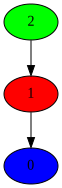

In [26]:
# Plot Morse graph
CMGDB.PlotMorseGraph(morse_graph)

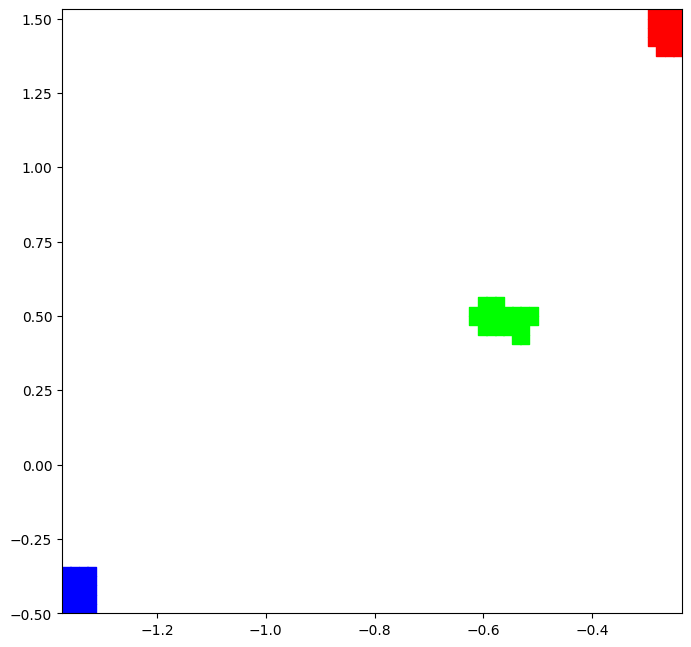

In [27]:
# Plot Morse sets
CMGDB.PlotMorseSets(morse_fname)